# Introduction to Quantum Machine Learning with qiskit

You might have been hearing some hype around quantum computing and how it will potentially revolutionize programming as we know it. While I am not completely on the hype train, I do find many of its applications somewhat promising and warranting some exploration. One of the more exciting ones is machine learning and AI, where quantum computing application here could produce models more accurate than its classical counterparts. Let's dive into a simple example of a quantum model and compare against a classical one to see what results can be yielded.

Keep in mind that quantum machine learning and quantum computing in general is still finding its footing so do not be surprised if crazy accuracies are not obtained from quantum models versus classical ones. Classical machine learning has existed and been researched and used in the industry for decades now so it only makes sense it could outperform quantum models right now.

In [1]:
!pip install qiskit
!pip install qiskit-machine-learning
!pip install pylatexenc

We will use the classical classification dataset, the iris dataset.

## Data Analysis

In [2]:
from sklearn.datasets import load_iris

iris_data = load_iris()
print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Some notes about the data:
* There are 150 data points, 3 classes, with even distribution of data points for each one
* Four features describing dimensions of the sepals and petals of the flowers exist
* No missing values exist (no imputation needed :D )
* High correlation exists among the petal features so maybe one could be used in place of both of them (could reduce dimensionality, if needed)
* Outliers may exist for petal length (may need to be removed)
* Means differ greatly (so scaling is needed)

Let's at least do some normalized scaling.

In [52]:
features = iris_data.data
targets = iris_data.target

In [53]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

Now would be good to visualize any more information about the data like correlations.

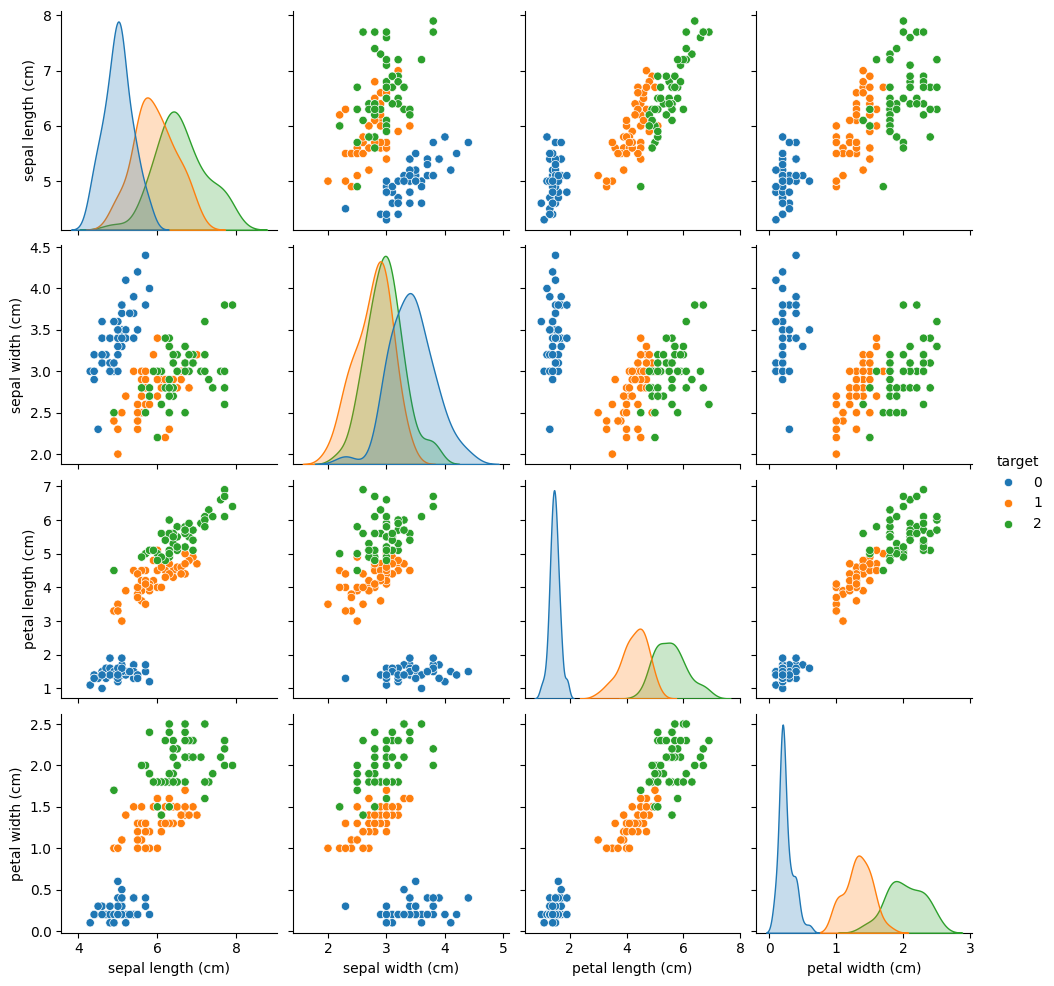

In [40]:
import pandas as pd
import seaborn as sns

features_df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
features_df['target'] = pd.Series(targets)

sns.pairplot(features_df, hue='target', palette='tab10')

Blue flowers appear to be more easily distinguishable versus the orange and green ones. This is good to note for examining errors when wanting to know what incorrect classifications the model is making.

There are also positive correlations like with petal length and width and sepal and petal length.

Now let's look at modeling.

## Classical vs. Quantum Machine Learning Models

First we will fit and predict with the classical support vector machine classification model.

In [8]:
!pip install qiskit.utils

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for qiskit.utils: filename=qiskit_utils-1.2.1-py3-none-any.whl size=6567 sha256=d6ea33b1610c6206bd52bc7a415a0f3dc68872ceb59a68e7f103c89ff1c731f4
  Stored in directory: c:\users\olive\appdata\local\pip\cache\wheels\0f\6a\a7\f5498da8f94e84c9bb32e88041d60b396415a7be82abdfb413
Successfully built qiskit.utils


In [54]:
import numpy as np
from sklearn.model_selection import train_test_split

# Set the seed for reproducibility
np.random.seed(123)

# Example of splitting data (assuming features and targets are defined)
train_features, test_features, train_targets, test_targets = train_test_split(
    features, targets, train_size=0.8, random_state=123
)


In [55]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_targets)

In [56]:
train_score = svc.score(train_features, train_targets)
test_score = svc.score(test_features, test_targets)

print(f"Training accuracy: {train_score:.2f}")
print(f"Testing accuracy: {test_score:.2f}")

Training accuracy: 0.99
Testing accuracy: 0.97


In [57]:
from sklearn.metrics import accuracy_score
from scipy.stats import wasserstein_distance
import numpy as np

# Get predictions for the test set
predictions = svc.predict(test_features)

# Calculate accuracy for reference (optional)
accuracy = accuracy_score(test_targets, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Calculate Wasserstein distance between the predicted and actual values
# Here, we assume both test_targets and predictions are discrete (e.g., class labels)

# Calculate the Wasserstein distance using scipy.stats.wasserstein_distance
wasserstein_dist = wasserstein_distance(test_targets, predictions)

print(f"Wasserstein distance: {wasserstein_dist:.2f}")



Accuracy: 0.97
Wasserstein distance: 0.03


As expected, great accuracies with the SVM, albeit on a very clean and easy dataset.

Next is the quantum model. A simple one to use is the variational quantum classifier (VQC). However a lot of prepping is required to instantiate the model.

First there is the feature map. The data must be encoded from regular bits to quantum bits, or qubits, to be used with a quantum model.

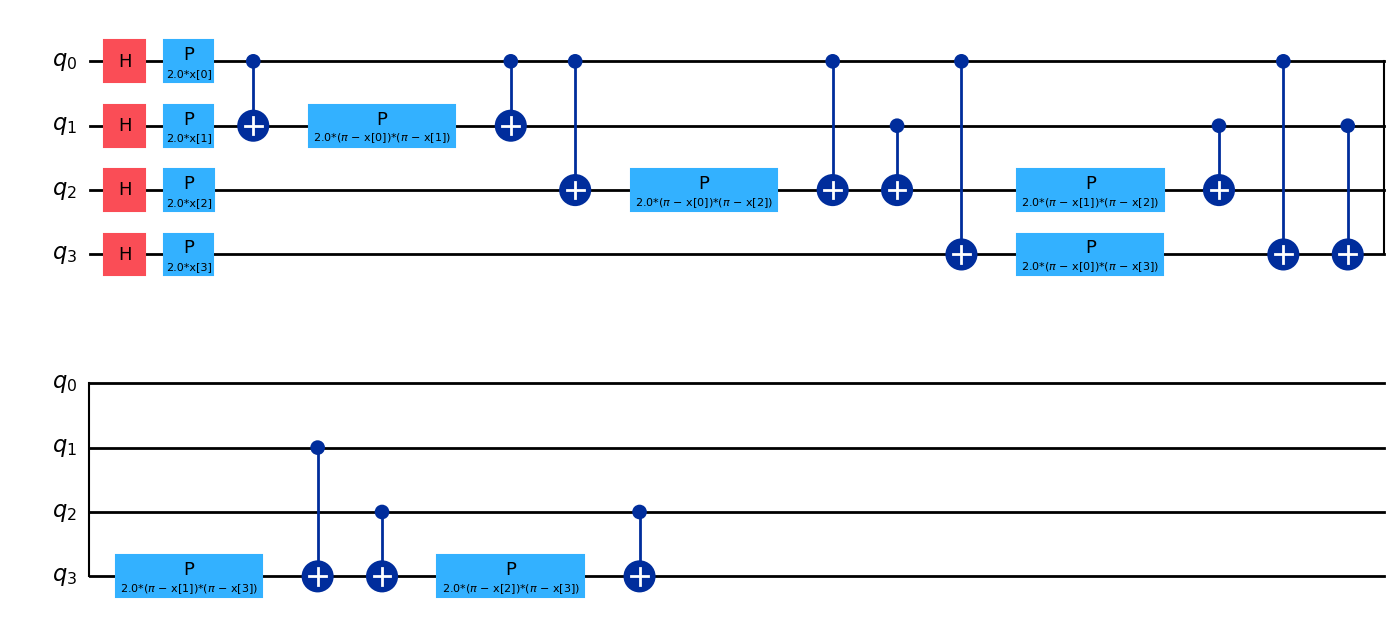

In [58]:
from qiskit.circuit.library import ZZFeatureMap

num_feats = features.shape[1]

feat_map = ZZFeatureMap(feature_dimension=num_feats, reps=1)
feat_map.decompose().draw('mpl', fold=20)

Next we must create an ansatz, which is a parameterized quantum circuit that is like layers of a neural network, with tunable parameters or weights that minimize the objective function.

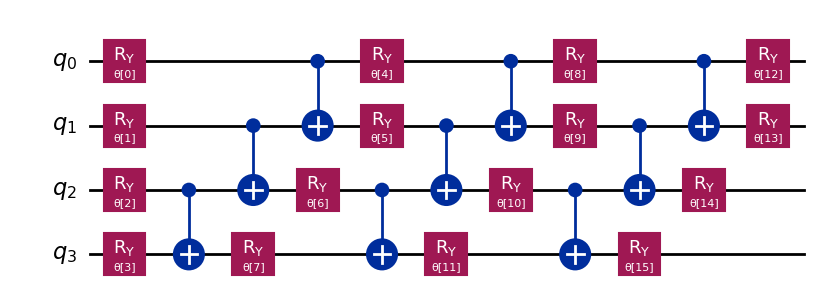

In [59]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_feats, reps=3)
ansatz.decompose().draw('mpl', fold=20)

The parameters θ[0] through θ[15] are the weights of the classifier, which will be optimized in training of the model.

Speaking of, we need an objective function to use for updating the weights of the classifier. A gradient-free function will be chosen to speed up the training process here.

In [60]:
!pip install qiskit_algorithms

In [61]:
import qiskit_algorithms.optimizers
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=50)

Then we need to specify where to train our model, on a quantum computer or a simulation of one on a classical computer. We will choose to simulate to also speed up training here.

In [62]:
from qiskit.primitives import Sampler

sampler = Sampler()

C:\Users\olive\AppData\Local\Temp\ipykernel_8604\2087805081.py:3: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


We will finally choose to add a callback function when the model has finished a training iteration. It will append the current weights and value of the loss function to a list. This will be used to plot performance during training once it has finished.

In [63]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = list()
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Now we can construct a VQC model.

In [64]:
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(feature_map=feat_map, ansatz=ansatz, optimizer=optimizer, sampler=sampler, callback=callback_graph)

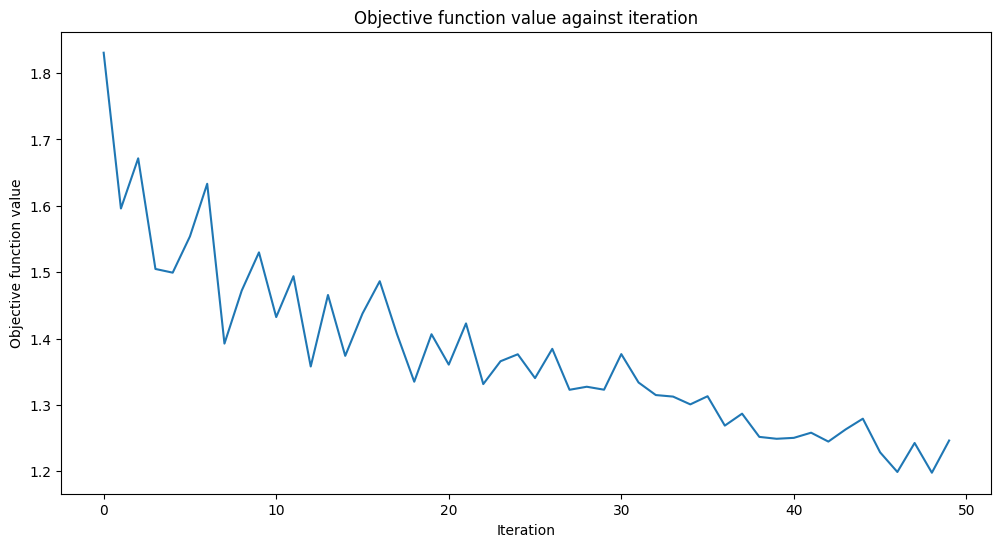

In [65]:
#reset values
objective_func_vals = list()

#train
vqc.fit(train_features, train_targets)

Seems like it has optimized well. But how does it perform overall in training and testing?

In [66]:
vqc_train_score = vqc.score(train_features, train_targets)
vqc_test_score = vqc.score(test_features, test_targets)

print(f"Training accuracy: {vqc_train_score:.2f}")
print(f"Testing accuracy: {vqc_test_score:.2f}")

Training accuracy: 0.76
Testing accuracy: 0.70


As expected, while not too poor in performance, the quantum model was about 10% worse than the classical SVM model. Its accuracy could be improved though by trying different optimization functions, feature maps, quantum circuits, or even reducing the number of features or dimensions of the data.

I hope you enjoyed learning about quantum machine learning and feel inspired to try out modeling it yourself on other datasets or constructing different models to see what interesting discoveries you make :D

In [84]:
# Assuming you already have trained your VQC model
vqc_train_score = vqc.score(train_features, train_targets)
vqc_test_score = vqc.score(test_features, test_targets)

print(f"Training accuracy: {vqc_train_score:.2f}")
print(f"Testing accuracy: {vqc_test_score:.2f}")

# Get predictions using the VQC
vqc_predictions = vqc.predict(test_features)


Training accuracy: 0.76
Testing accuracy: 0.70


In [85]:
import numpy as np

def create_distribution(labels, predicted_labels):
    distributions = []
    for label, pred_label in zip(labels, predicted_labels):
        if label == 0:
            actual_prob = [0.8, 0.2]  # High probability for actual 0
        else:
            actual_prob = [0.2, 0.8]  # High probability for actual 1

        # For predicted values
        if pred_label == 0:
            predicted_prob = [0.8, 0.2]  # Predicted as 0
        else:
            predicted_prob = [0.2, 0.8]  # Predicted as 1

        distributions.append((actual_prob, predicted_prob))
    return distributions

# Create distributions
distributions = create_distribution(test_targets, vqc_predictions)


In [90]:
from qiskit_aer import Aer
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit.quantum_info import state_fidelity
import numpy as np

# Encoding probability distributions into quantum states
def encode_distribution_to_quantum_state(probabilities):
    # Binary classification: we need 1 qubit to represent 2 possible states
    num_qubits = 1  # Since we're working with binary classification
    
    # Create a quantum circuit for 1 qubit
    qc = QuantumCircuit(num_qubits)
    
    # Convert the probability distribution to a state vector, where the 
    # probabilities are the amplitudes of the quantum state
    state_vector = np.array([np.sqrt(probabilities[0]), np.sqrt(probabilities[1])])
    
    # Normalize the state vector
    norm = np.linalg.norm(state_vector)
    state_vector = state_vector / norm
    
    # Apply initialization to the quantum circuit
    qc.initialize(state_vector, 0)  # Initialize on qubit 0
    
    # Simulate on the quantum backend (StatevectorSimulator for statevector calculation)
    backend = Aer.get_backend('statevector_simulator')
    new_circuit = transpile(qc, backend)
    job = backend.run(new_circuit)
    result = job.result()
    
    # Get the final statevector (quantum state representation)
    state_vector_result = result.get_statevector(qc)
    
    return state_vector_result

# Example distributions (this should come from your predicted and actual values)
# For example, actual probabilities and predicted probabilities for binary classification
actual_prob = [0.8, 0.2]  # Actual distribution: actual label 0 with high probability
predicted_prob = [0.2, 0.8]  # Predicted distribution: predicted label 1 with high probability

# Step 1: Encode actual and predicted distributions into quantum states
actual_quantum_state = encode_distribution_to_quantum_state(actual_prob)
predicted_quantum_state = encode_distribution_to_quantum_state(predicted_prob)

# Step 2: Calculate Fidelity for the pair of quantum states
fidelity = state_fidelity(actual_quantum_state, predicted_quantum_state)

print(f"Quantum Fidelity between actual and predicted distributions: {fidelity:.2f}")


Quantum Fidelity between actual and predicted distributions: 0.64
